# 분류 리뷰

In [ ]:
import pandas as pd
data = pd.read_csv("satimage.csv")
data.shape
data.y.value_counts()

In [ ]:
data.describe().iloc[2,:].sort_values(ascending=False)

- x1~x36 중 분산이 큰 변수의 y값별 평균 차이

In [9]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

# 분산분석 모델 적합
model = ols('x18 ~ C(y)', data=data).fit()
anova_results = anova_lm(model)

print(anova_results)

              df        sum_sq        mean_sq            F  PR(>F)
C(y)         5.0  2.642104e+06  528420.833307  4631.880121     0.0
Residual  6429.0  7.334425e+05     114.083443          NaN     NaN


- 유의미한 차이인 경우 Tukey HSD Test

In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Tukey 사후검정
tukey = pairwise_tukeyhsd(endog=data['x18'],
                          groups=data['y'],
                          alpha=0.05)

print(tukey.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper   reject
-----------------------------------------------------
     0      1 -55.9926   0.0 -57.3794 -54.6057   True
     0      2  10.0752   0.0   8.9406  11.2098   True
     0      3  -4.7763   0.0  -6.2205  -3.3322   True
     0      4 -33.1027   0.0 -34.4868 -31.7185   True
     0      5 -17.8738   0.0 -18.9781 -16.7695   True
     1      2  66.0678   0.0  64.6531  67.4825   True
     1      3  51.2163   0.0  49.5431  52.8894   True
     1      4  22.8899   0.0  21.2682  24.5116   True
     1      5  38.1188   0.0  36.7283  39.5093   True
     2      3 -14.8515   0.0 -16.3224 -13.3807   True
     2      4 -43.1779   0.0 -44.5899 -41.7659   True
     2      5  -27.949   0.0  -29.088   -26.81   True
     3      4 -28.3264   0.0 -29.9973 -26.6554   True
     3      5 -13.0975   0.0 -14.5451 -11.6499   True
     4      5  15.2289   0.0  13.8411  16.6167   True
----------------------------

- 데이터 전처리

In [14]:
#data.isnull().mean()
data.y.unique()
y_ohe = pd.get_dummies(  data.y )
y_ohe

,0,1,2,3,4,5
0,False,False,True,False,False,False
1,False,False,True,False,False,False
2,False,False,True,False,False,False
3,False,False,True,False,False,False
4,False,False,True,False,False,False
...,...,...,...,...,...,...
6430,True,False,False,False,False,False
6431,False,False,False,False,True,False
6432,False,False,False,False,True,False
6433,False,False,False,False,True,False


- X, y, 파티셔닝

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("y", axis=1),
    y_ohe,
    test_size=0.2,
    random_state=1)

- 앙상블 적용: boosting vs bagging

In [ ]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf = RandomForestClassifier().fit(X_train, y_train)
print( classification_report( y_test, rf.predict(X_test) ) )

gb = XGBClassifier().fit(X_train, y_train)
print( classification_report( y_test, gb.predict(X_test) ) )

- 하이퍼파라미터 서치

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid ={"n_estimators":[50,100,150], "max_depth":[5,6]   }

gs = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    cv=3,
    scoring="accuracy"
)
gs.fit(X_train, y_train)
print(gs.best_params_)

{'max_depth': 6, 'n_estimators': 150}


- 성능 평가

In [29]:
import numpy as np
gs.best_estimator_.score(X_test, y_test)
pred = gs.best_estimator_.predict(X_test)
pred2 = np.argmax( pred, axis=1)
y_test2 = np.argmax( y_test.values, axis=1)
print( classification_report(y_test2, pred2  ))

              precision    recall  f1-score   support

           0       0.66      1.00      0.79       306
           1       1.00      0.90      0.95       143
           2       0.89      0.92      0.90       261
           3       0.89      0.28      0.42       123
           4       0.97      0.72      0.82       137
           5       0.90      0.80      0.85       317

    accuracy                           0.83      1287
   macro avg       0.89      0.77      0.79      1287
weighted avg       0.86      0.83      0.81      1287



# SPC : Control Chart

##1. x-bar chart and R chart

In [ ]:
#라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

# 예제 데이터:정규분포
x = np.array([list(np.random.normal(loc=10, scale=2, size=5)),
        list(np.random.normal(loc=10, scale=2, size=5)),
        list(np.random.normal(loc=10, scale=2, size=5)),
        list(np.random.normal(loc=10, scale=2, size=5)),
        list(np.random.normal(loc=10, scale=2, size=5)),
        list(np.random.normal(loc=17, scale=2, size=5)),
        list(np.random.normal(loc=10, scale=2, size=5)),
        list(np.random.normal(loc=10, scale=2, size=5)),
        list(np.random.normal(loc=10, scale=2, size=5)),
        list(np.random.normal(loc=10, scale=2, size=5))])

x

array([[10.99342831,  9.7234714 , 11.29537708, 13.04605971,  9.53169325],
       [ 9.53172609, 13.15842563, 11.53486946,  9.06105123, 11.08512009],
       [ 9.07316461,  9.06854049, 10.48392454,  6.17343951,  6.55016433],
       [ 8.87542494,  7.97433776, 10.62849467,  8.18395185,  7.1753926 ],
       [12.93129754,  9.5484474 , 10.13505641,  7.15050363,  8.91123455],
       [17.22184518, 14.69801285, 17.75139604, 15.79872262, 16.4166125 ],
       [ 8.79658678, 13.70455637,  9.97300555,  7.88457814, 11.64508982],
       [ 7.5583127 , 10.41772719,  6.08065975,  7.3436279 , 10.39372247],
       [11.47693316, 10.34273656,  9.76870344,  9.39779261,  7.04295602],
       [ 8.56031158,  9.07872246, 12.11424445, 10.68723658,  6.47391969]])

In [ ]:
# 그룹 평균 저장 리스트
x_bar = []

# 그룹 Range 저장 리스트
r = []

# 계산 결과 저장
for group in x:
    x_bar.append(group.mean())
    r.append(group.max() - group.min())

x_bar

[np.float64(10.918005948650173),
 np.float64(10.874238498144853),
 np.float64(8.269846699204994),
 np.float64(8.56752036246535),
 np.float64(9.735307904953721),
 np.float64(16.377317836368462),
 np.float64(10.40076333227556),
 np.float64(8.358810003249861),
 np.float64(9.605824357136171),
 np.float64(9.382886952428057)]

[Text(0.5, 0, 'Group'), Text(0, 0.5, 'Range')]

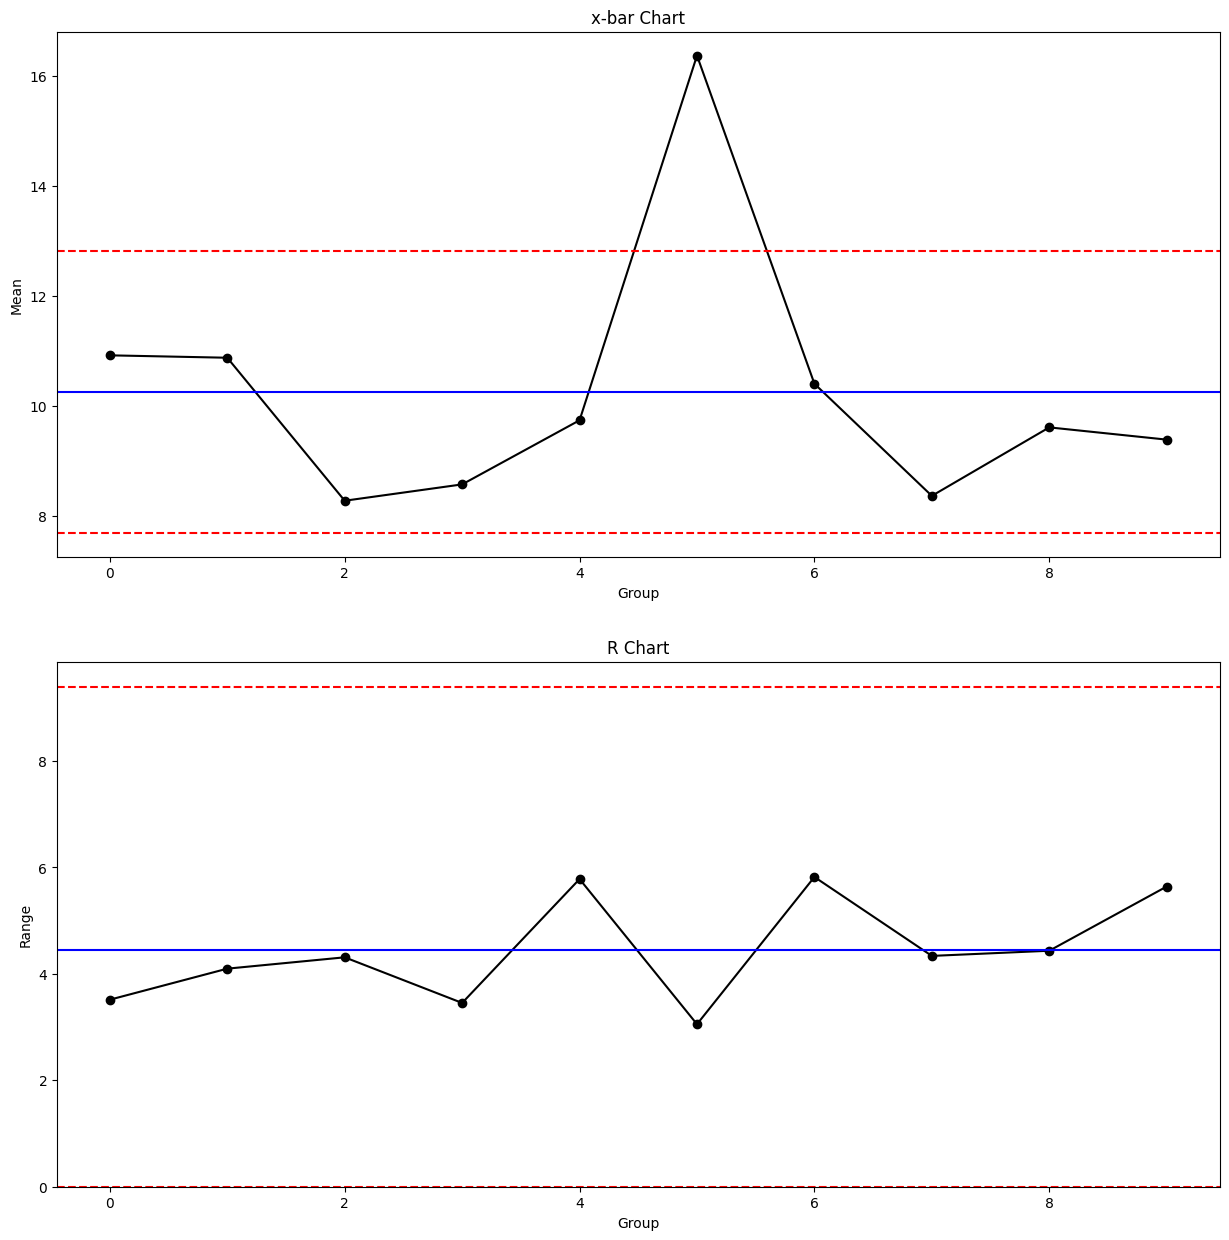

In [ ]:
# Plot x-bar and R charts
fig, axs = plt.subplots(2, figsize=(15,15))

# x-bar chart
axs[0].plot(x_bar, linestyle='-', marker='o', color='black')
axs[0].axhline((np.mean(x_bar)+0.577*np.mean(r)), color='red', linestyle='dashed')
axs[0].axhline((np.mean(x_bar)-0.577*np.mean(r)), color='red', linestyle='dashed')
axs[0].axhline((np.mean(x_bar)), color='blue')
axs[0].set_title('x-bar Chart')
axs[0].set(xlabel='Group', ylabel='Mean')

# R chart
axs[1].plot(r, linestyle='-', marker='o', color='black')
axs[1].axhline((2.114*np.mean(r)), color='red', linestyle='dashed')
axs[1].axhline((0*np.mean(r)), color='red', linestyle='dashed')
axs[1].axhline((np.mean(r)), color='blue')
axs[1].set_ylim(bottom=0)
axs[1].set_title('R Chart')
axs[1].set(xlabel='Group', ylabel='Range')


In [ ]:
# CL 넘는 점의 개수 찾기
i = 0
control = True

for group in x_bar:
    if group > np.mean(x_bar)+0.577*np.mean(r) or group < np.mean(x_bar)-0.577*np.mean(r):
        print('Group', i, 'out of mean control limits!')
        control = False
    i += 1

if control == True:
    print('X bar chart: All points within control limits.')

# Validate points out of control limits for R chart
i = 0
control = True
for group in r:
    if group > 2.114*np.mean(r):
        print('Group', i, 'out of range cotrol limits!')
        control = False
    i += 1

if control == True:
    print('R chart: All points within control limits.')

Group 5 out of mean control limits!
R chart: All points within control limits.


##2. x-bar chart and s chart

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(42)

# Create dummy data
x = np.array([list(np.random.normal(loc=10, scale=2, size=11)),
        list(np.random.normal(loc=10, scale=2, size=11)),
        list(np.random.normal(loc=10, scale=2, size=11)),
        list(np.random.normal(loc=10, scale=2, size=11)),
        list(np.random.normal(loc=10, scale=2, size=11)),
        list(np.random.normal(loc=10, scale=2, size=11)),
        list(np.random.normal(loc=10, scale=2, size=11)),
        list(np.random.normal(loc=13, scale=2, size=11)),
        list(np.random.normal(loc=10, scale=2, size=11)),
        list(np.random.normal(loc=10, scale=2, size=11))])

# Define list variable for groups means
x_bar = []

# Define list variable for groups standard deviation
s = []

# Get and append groups means and standard deviations
for group in x:
    x_bar.append(group.mean())
    s.append(np.std(group))


[Text(0.5, 0, 'Group'), Text(0, 0.5, 'Range')]

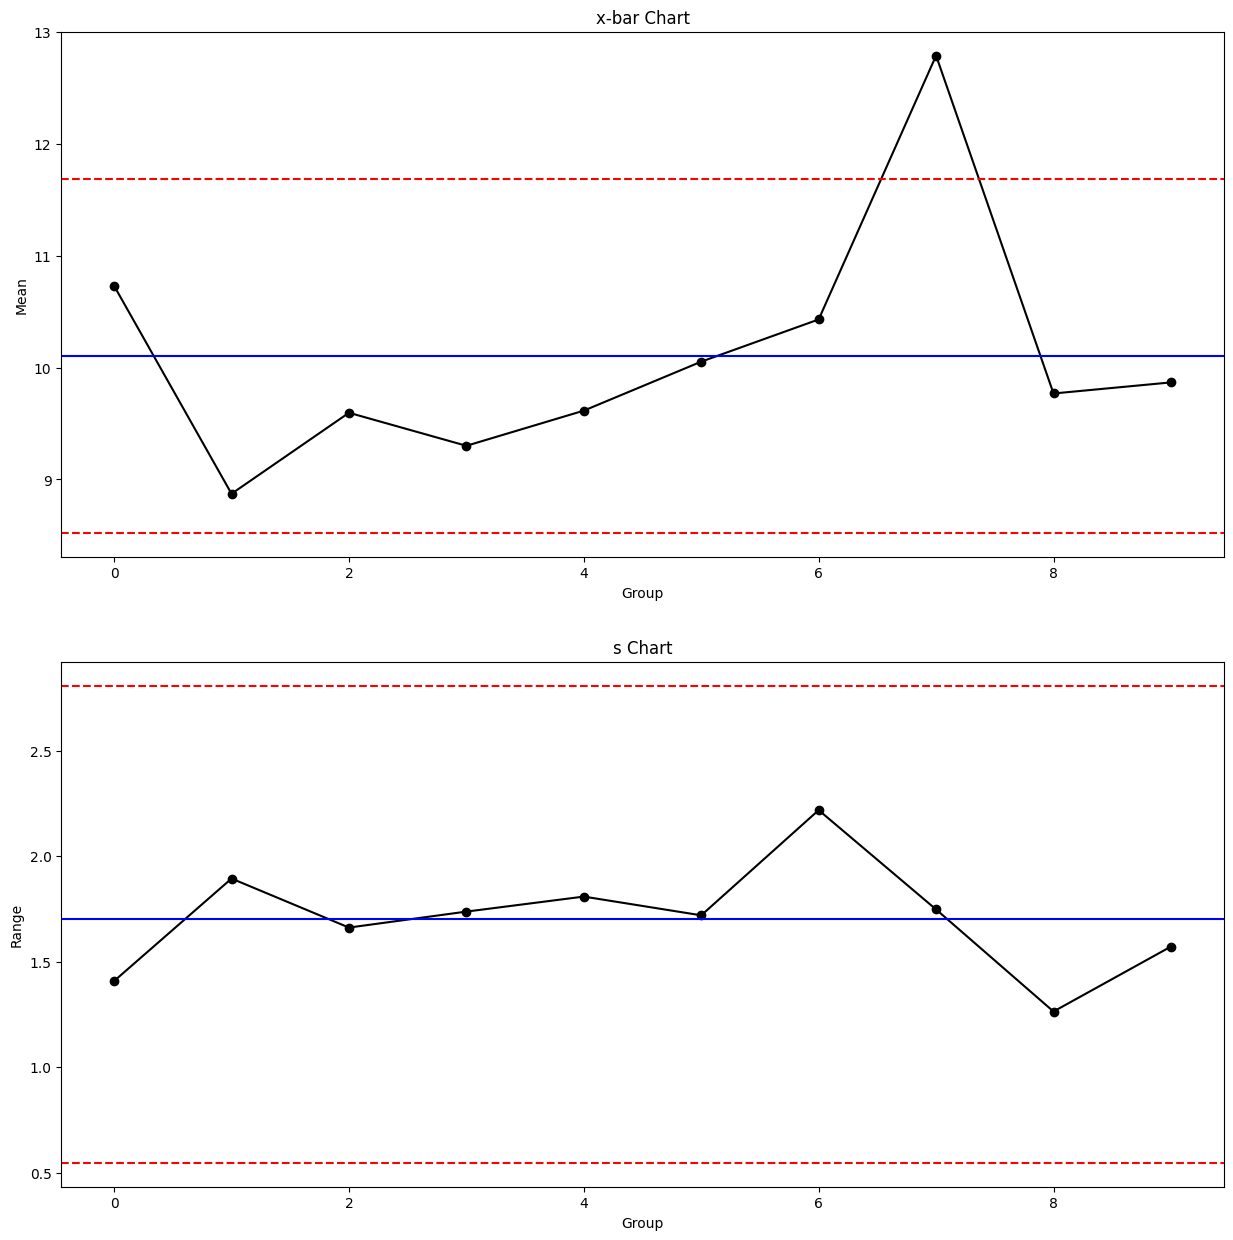

In [ ]:
# Plot x-bar and s charts
fig, axs = plt.subplots(2, figsize=(15,15))

# x-bar chart
axs[0].plot(x_bar, linestyle='-', marker='o', color='black')
axs[0].axhline((np.mean(x_bar)+0.927*np.mean(s)), color='red', linestyle='dashed')
axs[0].axhline((np.mean(x_bar)-0.927*np.mean(s)), color='red', linestyle='dashed')
axs[0].axhline((np.mean(x_bar)), color='blue')
axs[0].set_title('x-bar Chart')
axs[0].set(xlabel='Group', ylabel='Mean')

# s chart
axs[1].plot(s, linestyle='-', marker='o', color='black')
axs[1].axhline((1.649*np.mean(s)), color='red', linestyle='dashed')
axs[1].axhline((0.321*np.mean(s)), color='red', linestyle='dashed')
axs[1].axhline((np.mean(s)), color='blue')
axs[1].set_title('s Chart')
axs[1].set(xlabel='Group', ylabel='Range')



In [ ]:
# Validate points out of control limits for x-bar chart
i = 0
control = True
for group in x_bar:
    if group > np.mean(x_bar)+0.927*np.mean(s) or group < np.mean(x_bar)-0.927*np.mean(s):
        print('Group', i, 'out of mean control limits!')
        control = False
    i += 1
if control == True:
    print('X bar chart: All points within control limits.')



Group 7 out of mean control limits!


In [ ]:
# Validate points out of control limits for s chart
i = 0
control = True
for group in s:
    if group > 1.649*np.mean(s) or group < 0.321*np.mean(s):
        print('Group', i, 'out of standard deviation cotrol limits!')
        control = False
    i += 1
if control == True:
    print('R chart: All points within control limits.')

R chart: All points within control limits.


##3. 제조 데이터

In [30]:
!unzip secom.zip
#모형 개선
#모니터링 변수 발견
#샘플링 조정
#XS차트

Archive:  secom.zip
  inflating: secom.data              
  inflating: secom.names             
  inflating: secom_labels.data       


In [31]:
import pandas as pd
X = pd.read_csv("secom.data", sep=" ", header=None)
y = pd.read_csv("secom_labels.data", sep=" ", header=None )

X.columns = ["X"+str(i) for i in range(X.shape[1])]
y.columns = ["target", "time"]
df = pd.concat([X, y], axis=1)
df.time = pd.to_datetime(df.time, dayfirst=True)
df.set_index("time", inplace=True)
df.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X581,X582,X583,X584,X585,X586,X587,X588,X589,target
time,,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [32]:
from sklearn.model_selection import train_test_split
target_ohe = pd.get_dummies(df.target)
X_train, X_test, y_train, y_test = train_test_split(df.drop("target", axis=1), target_ohe, test_size=0.2, stratify=target_ohe, random_state=1)


In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
dt = RandomForestClassifier().fit(X_train, y_train)
####

In [38]:
feature_importance = pd.Series( dt.feature_importances_)
feature_importance.index = X_train.columns
feature_importance.sort_values(ascending=False, inplace=True)
feature_importance.head()

,0
X426,0.010215
X64,0.008435
X65,0.008114
X40,0.007779
X288,0.007466


In [40]:
df.describe().iloc[2,:].sort_values(ascending=False)

,std
X162,6553.569317
X161,4239.245058
X297,3226.924298
X24,2902.690117
X296,1975.111365
...,...
X538,0.000000
X537,0.000000
X536,0.000000
X97,0.000000


In [ ]:
feature_importance.head()
####분산

,0
X480,0.068762
X413,0.058614
X477,0.050745
X304,0.043897
X120,0.041686


In [46]:
df = df.sort_index()  # 시간순 정렬

# 특정 시 간격 그룹화 후 X480에서 5개 샘플링
sampled = (
    df.groupby(pd.Grouper(freq='2D'))['X426']
    .apply(lambda x: x.sample(n=10, replace=True).reset_index(drop=True))
    .unstack()  # 행 → 열 변환
)

# 컬럼 이름 지정 (X480_1, X480_2, ...)
sampled.columns = [f"X426_{i+1}" for i in range(sampled.shape[1])]

In [47]:
sampled

,X426_1,X426_2,X426_3,X426_4,X426_5,X426_6,X426_7,X426_8,X426_9,X426_10
time,,,,,,,,,,
2008-07-19,1.7250,1.8942,1.8268,1.4857,1.7250,1.7250,1.9245,1.8268,1.9544,1.7275
2008-07-21,1.3003,1.3003,1.4406,1.4616,1.5012,1.4197,3.5863,3.5863,1.4616,1.0833
2008-07-23,1.7251,1.7251,1.4638,1.7251,1.4638,1.4638,1.4638,1.4638,1.4638,1.7251
2008-07-25,1.5379,1.5379,1.5379,1.5379,1.5379,1.5379,1.5379,1.5379,1.5379,1.5379
2008-07-27,2.2223,2.2223,1.7651,2.2207,1.2867,1.2867,1.6680,2.2207,1.9298,0.8767
2008-07-29,1.7925,1.1893,1.2029,1.3234,1.5114,1.3234,1.3993,2.0277,1.1893,1.3234
2008-07-31,1.4987,0.7839,0.8118,0.7478,1.9036,1.7486,1.9036,0.8118,0.9742,0.7478
2008-08-02,1.5858,1.5905,1.1592,1.1992,1.1157,1.1157,2.3661,1.5905,1.1157,0.9558
2008-08-04,19.7458,2.2588,2.0198,1.1393,1.2543,1.2543,1.4659,0.5947,1.2508,2.0322


In [48]:
# Create dummy data
x = sampled.values

# Define list variable for groups means
x_bar = []

# Define list variable for groups standard deviation
s = []

# Get and append groups means and standard deviations
for group in x:
    x_bar.append(group.mean())
    s.append(np.std(group))


[Text(0.5, 0, 'Group'), Text(0, 0.5, 'Range')]

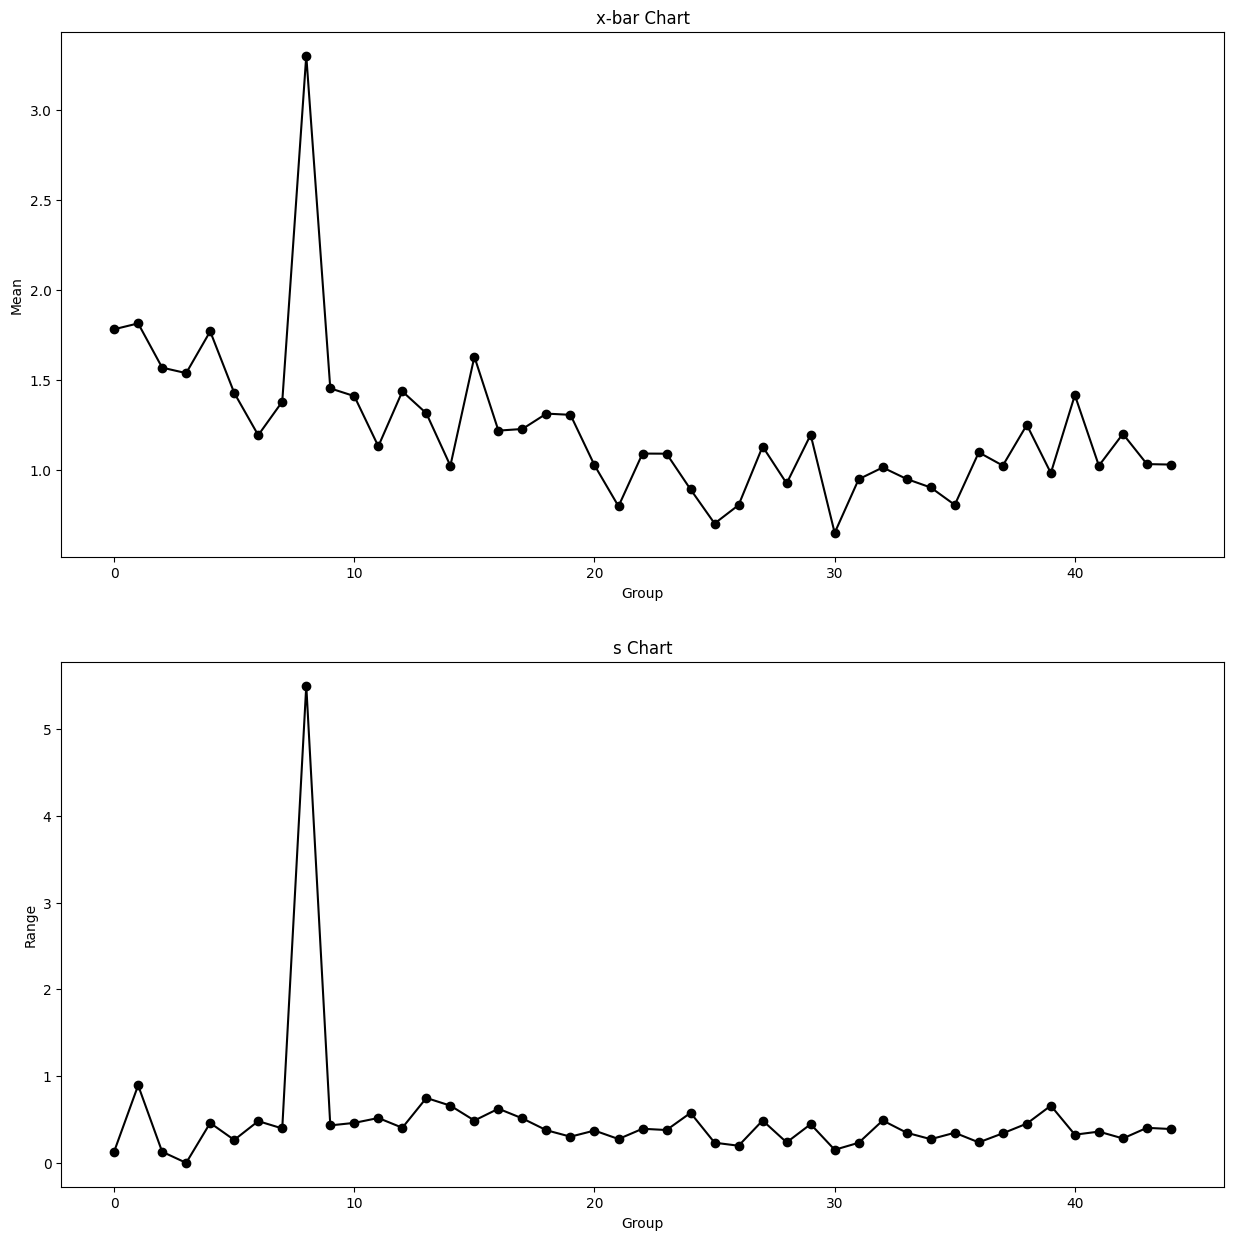

In [50]:
# Plot x-bar and s charts
from matplotlib import pyplot as plt
fig, axs = plt.subplots(2, figsize=(15,15))

# x-bar chart
axs[0].plot(x_bar, linestyle='-', marker='o', color='black')
axs[0].axhline((np.mean(x_bar)+0.927*np.mean(s)), color='red', linestyle='dashed')
axs[0].axhline((np.mean(x_bar)-0.927*np.mean(s)), color='red', linestyle='dashed')
axs[0].axhline((np.mean(x_bar)), color='blue')
axs[0].set_title('x-bar Chart')
axs[0].set(xlabel='Group', ylabel='Mean')

# s chart
axs[1].plot(s, linestyle='-', marker='o', color='black')
axs[1].axhline((1.649*np.mean(s)), color='red', linestyle='dashed')
axs[1].axhline((0.321*np.mean(s)), color='red', linestyle='dashed')
axs[1].axhline((np.mean(s)), color='blue')
axs[1].set_title('s Chart')
axs[1].set(xlabel='Group', ylabel='Range')



In [ ]:
# Validate points out of control limits for x-bar chart
i = 0
control = True
for group in x_bar:
    if group > np.mean(x_bar)+0.927*np.mean(s) or group < np.mean(x_bar)-0.927*np.mean(s):
        print('Group', i, 'out of mean control limits!')
        control = False
    i += 1
if control == True:
    print('X bar chart: All points within control limits.')



Group 0 out of mean control limits!
Group 1 out of mean control limits!
Group 7 out of mean control limits!
Group 11 out of mean control limits!
Group 14 out of mean control limits!
Group 17 out of mean control limits!


In [ ]:
# Validate points out of control limits for s chart
i = 0
control = True
for group in s:
    if group > 1.649*np.mean(s) or group < 0.321*np.mean(s):
        print('Group', i, 'out of standard deviation cotrol limits!')
        control = False
    i += 1
if control == True:
    print('R chart: All points within control limits.')

Group 0 out of standard deviation cotrol limits!
Group 7 out of standard deviation cotrol limits!
Group 9 out of standard deviation cotrol limits!
